In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import networkx as nx
import dgl
from cycler import cycler
from umap import UMAP
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from graph_env.environ import GraphEnv
from graph_env.agent import DQN, train, eval, noise_decay

/Users/williamarliss/Desktop/school/STAT-8289/rlenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/williamarliss/Desktop/school/STAT-8289/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcdefaults()
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'w'
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams['font.family'] = 'arial'

In [3]:
### Configuration ###

### Environment/Graph ###
n_components = 25
num_communities = 10
n_iter_no_change = 10
max_iter = 100
min_change = 0.001
# min_change = 0.002
# min_change = 0.0025
# min_change = 0.003

### Agent ###
hidden_dim = 400
eta = 0.0001
mem_size = 2048
num_eval_episodes = 10
save_path = './model_pubmed_2'

### Training ###
burn_in = 512
train_steps = 9
update_freq = 3
batch_size = 16
gamma = 0.9
tau = 0.01
exploration_rate = 0.999
exploration_decay = 1e-5
num_episodes = 2_500


In [4]:
# expl = float(exploration_rate)
# n_eps = int(num_episodes)
# gamma = float(exploration_decay)
# trace = []
# for episode in range(n_eps):
#     expl = noise_decay(expl, episode, gamma)
#     trace.append(expl)
# plt.plot(trace);
# plt.xlim([0, 3000])
# del expl, n_eps, gamma, trace, episode

In [5]:
graph = dgl.data.PubmedGraphDataset()[0]
full_features = csr_matrix(graph.ndata['feat'])
graph.ndata['feat'] = torch.tensor(
    TruncatedSVD(n_components=n_components).fit_transform(full_features)
).to(graph.ndata['feat'])

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [6]:
def prune(G, min_degree=0):
    G = G.copy()
    while True:
        nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < min_degree]
        if len(nodes_to_remove) == 0:
            return G
        G.remove_nodes_from(nodes_to_remove)

In [7]:
G = nx.Graph(dgl.to_networkx(graph))
G = prune(G, min_degree=3)
graph = graph.subgraph(list(G.nodes()))
full_features = csr_matrix(graph.ndata['feat'])
del G

In [8]:
env = GraphEnv(graph, num_communities=num_communities,
               n_iter_no_change=n_iter_no_change, max_iter=max_iter, min_change=min_change)
adapter = env.get_adapter(features=graph.ndata['feat'])

In [9]:
agent = DQN(
    adapter,
    hidden_dim=hidden_dim,
    eta=eta,
    mem_size=mem_size,
)

---
### Training

In [ ]:
preds, eval_history = eval(env, agent, num_episodes=num_eval_episodes, verbose=False)
np.mean([env.compute_modularity(p) for p in preds])

In [ ]:
train_history = train(
    env=env,
    agent=agent,
    burn_in=burn_in,
    train_steps=train_steps,
    update_freq=update_freq,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    exploration_rate=exploration_rate,
    exploration_decay=exploration_decay,
    num_episodes=num_episodes,
    verbose=True,
    save_path=save_path,
)

In [10]:
train_history = pd.read_csv(os.path.join(save_path, 'history.csv'))

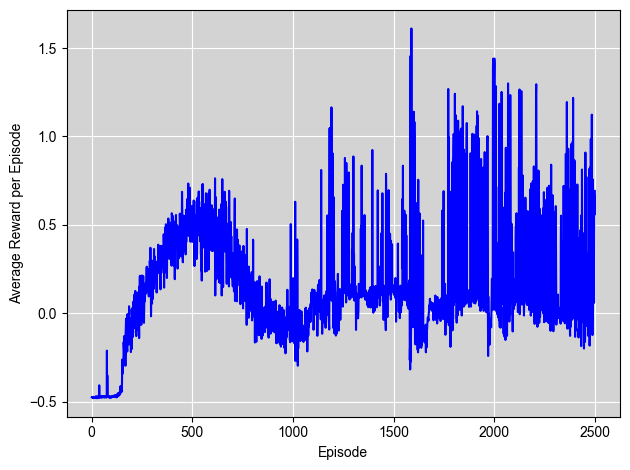

In [11]:
train_history.groupby('episode')['reward'].mean().plot();
plt.ylabel('Average Reward per Episode')
# train_history.groupby('episode')['reward'].sum().plot();
# plt.ylabel('Total Reward per Episode')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()

In [12]:
# train_history.groupby('episode')['exploration'].mean().plot();
# plt.ylabel('Exploration Rate per Episode')
# plt.xlabel('Episode')
# plt.tight_layout()
# plt.show()

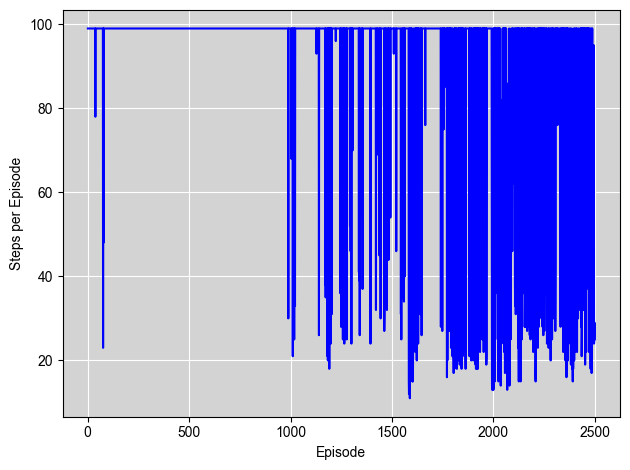

In [13]:
train_history.groupby('episode').size().plot();
plt.ylabel('Steps per Episode')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()

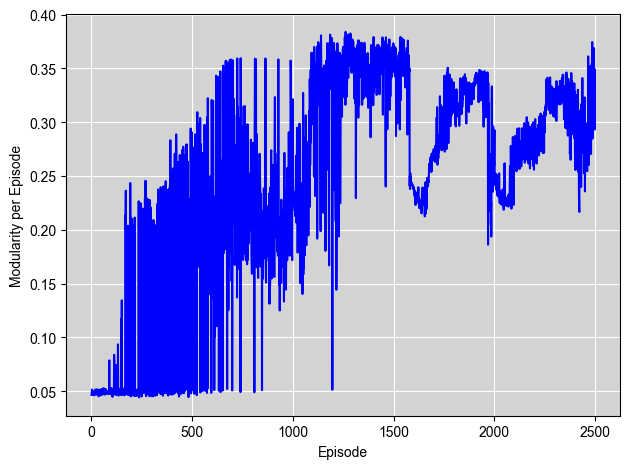

In [14]:
train_history.groupby('episode')['modularity'].apply(lambda x: list(x)[-1]).plot();
plt.ylabel('Modularity per Episode')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()

---
### Evaluation

In [29]:
agent.load(save_path)

In [30]:
preds, eval_history = eval(env, agent, num_episodes=num_eval_episodes, verbose=False)
scores = [env.compute_modularity(p) for p in preds]
np.mean(scores), np.std(scores), np.max(scores)

/Users/williamarliss/Desktop/school/STAT-8289/rl-final/graph_env/agent.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([


(0.3522679001092911, 0.00557656034957601, 0.3628750443458557)

In [31]:
num_comms = [np.unique(p).size for p in preds]
np.mean(num_comms), np.std(num_comms)

(7.0, 0.0)

In [32]:
lab = graph.ndata['label'].numpy()
env.compute_modularity(lab)

0.3099578320980072

In [33]:
pred = max(preds, key=lambda p: env.compute_modularity(p))
env.compute_modularity(pred), np.unique(pred).size

(0.3628750443458557, 7)

In [34]:
adjacency_matrix = graph.adj().to_dense().numpy()
degree_matrix = np.diag(adjacency_matrix.sum(1))
laplacian_matrix = degree_matrix - adjacency_matrix
laplacian_matrix = csr_matrix(laplacian_matrix)
laplacian_encoded = TruncatedSVD(n_components=graph.ndata['feat'].shape[1]).fit_transform(laplacian_matrix)
del adjacency_matrix, degree_matrix

In [35]:
reducer = UMAP(n_components=2, n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(full_features)
embedding += reducer.fit_transform(laplacian_matrix)/5
# embedding = reducer.fit_transform(laplacian_matrix)
# embedding = reducer.fit_transform(np.hstack([graph.ndata['feat'].numpy(), laplacian_encoded]))

/Users/williamarliss/Desktop/school/STAT-8289/rlenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


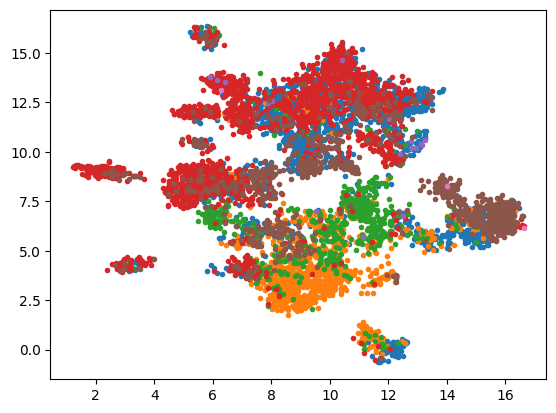

In [36]:
for p in np.unique(pred):
    plt.plot(*embedding[pred==p].T, '.')
plt.show()

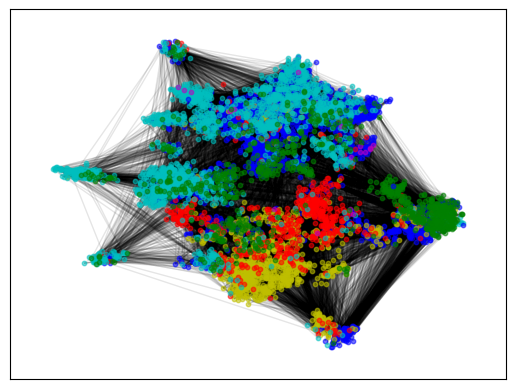

In [38]:
pos = {i: embedding[i] for i in range(graph.num_nodes())}
colors = 'byrcmgbyrcmg'
G = nx.Graph(graph.to_networkx())
plt.rcdefaults() #
fig, ax = plt.subplots()
nx.draw_networkx_edges(G, pos=pos, alpha=0.1, ax=ax)
for i, p in enumerate(np.unique(pred)):
    nx.draw_networkx_nodes(G.subgraph(np.where(pred==p)[0]), pos=pos, ax=ax, node_size=10, node_color=colors[i], alpha=0.55)

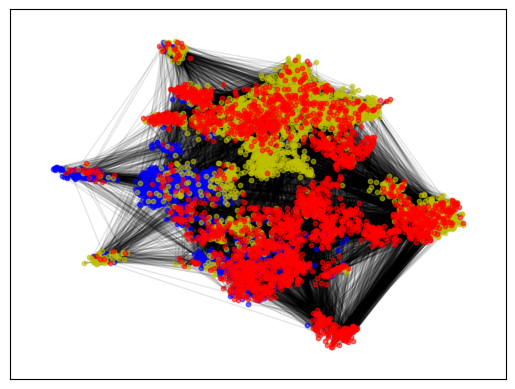

In [ ]:
colors = 'byrcmg'
G = nx.Graph(graph.to_networkx())
plt.rcdefaults() #
fig, ax = plt.subplots()
nx.draw_networkx_edges(G, pos=pos, alpha=0.1, ax=ax)
for i, l in enumerate(np.unique(lab)):
    nx.draw_networkx_nodes(G.subgraph(np.where(lab==l)[0]), pos=pos, ax=ax, node_size=10, node_color=colors[i], alpha=0.55)

---
### Baseline

In [25]:
G = graph.to_networkx()

In [26]:
louvain = np.zeros(graph.num_nodes(), dtype=int)
for idx, comm in enumerate(nx.community.louvain_communities(G, resolution=1)):
    for node in comm:
        louvain[node] = idx
idx+1

17

In [27]:
env2 = GraphEnv(env.graph, num_communities=idx+1)
env2.compute_modularity(louvain)

0.38291117548942566

In [28]:
results = []
for seed in range(num_eval_episodes):

    partition = np.zeros(graph.num_nodes(), dtype=int)
    for idx, comm in enumerate(nx.community.louvain_communities(G, seed=seed)):
        for node in comm:
            partition[node] = idx
    env2 = GraphEnv(env.graph, num_communities=np.unique(partition).size)
    mod = env2.compute_modularity(partition)
    results.append({'method': 'louvain', 'modularity': mod, 'num': np.unique(partition).size, 'seed': seed})

    partition = np.zeros(graph.num_nodes(), dtype=int)
    # for idx, comm in enumerate(nx.community.leiden_communities(G, seed=seed)):
    #     for node in comm:
    #         partition[node] = idx
    import leidenalg as la #
    import igraph as ig #
    partition = np.array(la.find_partition(ig.Graph.from_networkx(G), la.ModularityVertexPartition).membership) #
    env2 = GraphEnv(env.graph, num_communities=np.unique(partition).size)
    mod = env2.compute_modularity(partition)
    results.append({'method': 'leiden', 'modularity': mod, 'num': np.unique(partition).size, 'seed': seed})

    partition = np.zeros(graph.num_nodes(), dtype=int)
    for idx, comm in enumerate(nx.community.fast_label_propagation_communities(G, seed=seed)):
        for node in comm:
            partition[node] = idx
    env2 = GraphEnv(env.graph, num_communities=np.unique(partition).size)
    mod = env2.compute_modularity(partition)
    results.append({'method': 'lpa', 'modularity': mod, 'num': np.unique(partition).size, 'seed': seed})

pd.DataFrame(results).groupby('method')[['modularity', 'num']].agg(['mean', 'std', 'max'])

modularity                        num                
              mean       std       max   mean        std  max
method                                                       
leiden    0.389954  0.001141  0.391347   16.8   1.398412   19
louvain   0.383526  0.004168  0.387719   17.5   1.354006   20
lpa       0.352276  0.009533  0.362582  165.2  20.611755  197

---